# ELL793 Assignment 3 Part (b)
**ResNet-18: Pretrained+ Finetuning Last 2 FCs** <br>
Abhinava Sikdar 2017MT01724 <br>
Yashank Singh 2017MT10756

Some website:
https://github.com/kuangliu/pytorch-cifar/blob/master/main.py <br>
https://medium.com/@wwwbbb8510/lessons-learned-from-reproducing-resnet-and-densenet-on-cifar-10-dataset-6e25b03328da 

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

print('Is CUDA available', torch.cuda.is_available())
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))

Is CUDA available True
Torch 1.7.0+cu101 CUDA 10.1
Device: cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

## Handling Data

In [ ]:
data_path='../data/'
cifar=datasets.CIFAR10(data_path, train= True, download=True, transform=transforms.ToTensor())
cifar_val=datasets.CIFAR10(data_path, train=False, download= True, transform=transforms.ToTensor())

Extracting ../data/cifar-10-python.tar.gz to ../data/
Files already downloaded and verified


In [ ]:
cifar_stack = torch.stack([img for img, _ in cifar], dim=3)
print('Shape of the CIFAR stack is',cifar_stack.shape)
mean= cifar_stack.view(3,-1).mean(dim=1)
std= cifar_stack.view(3,-1).std(dim=1)
print('Mean of training data is', mean)
print('Standard deviation of training data is', std)


Shape of the CIFAR stack is torch.Size([3, 32, 32, 50000])
Mean of training data is tensor([0.4914, 0.4822, 0.4465])
Standard deviation of training data is tensor([0.2470, 0.2435, 0.2616])


In [ ]:
cifar_transformed = datasets.CIFAR10(data_path,train=True,download=False, transform=transforms.Compose([
                                                                                                        transforms.Resize(256),transforms.CenterCrop(224),
                                                                                                        transforms.ToTensor(),transforms.Normalize(mean,std)
]))
cifar_val_transformed = datasets.CIFAR10(data_path,train=False,download=False, transform=transforms.Compose([
                                                                                                              transforms.Resize(256),transforms.CenterCrop(224),
                                                                                                        transforms.ToTensor(),transforms.Normalize(mean,std)
]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


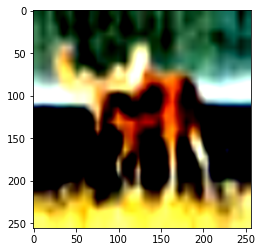

In [ ]:
img, label = cifar_transformed[28] 
plt.imshow(img.permute(1, 2, 0))
plt.show()

## Hparams and Loaders

In [ ]:
batch_size=512
val_batch_size=500
num_epochs=120

dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_loader=torch.utils.data.DataLoader(cifar_transformed,batch_size=batch_size,shuffle=True, num_workers=4)
train_acc_loader=torch.utils.data.DataLoader(cifar_transformed,batch_size=500,shuffle=False,num_workers=4)
val_loader = torch.utils.data.DataLoader(cifar_val_transformed, batch_size=val_batch_size, shuffle=False,num_workers=4)

# Model with fine tuninig only FC layer

In [ ]:
resnet18 =models.resnet18(pretrained=True, progress=True)
#Freezing the conv layers-------------------------------------------------------
for param in resnet18.parameters():
    param.requires_grad = False
#Adding 2 FC layer on top of conv net-------------------------------------------
num_ftrs = resnet18.fc.in_features
resnet18.fc=nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
          )
resnet18=resnet18.to(dev)
loss_func= torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


## Training

In [ ]:
max_validation = 0
max_epoch=0
val_acc=[]
train_acc=[]
epochs=[]

In [ ]:
for i in range(num_epochs):

  for imgs, labels in train_loader:
    if dev is not None:
      imgs,labels=imgs.to(dev),labels.to(dev)
    out= resnet18(imgs)
    loss=loss_func(out,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  correct_val = 0
  total_val = 0
  correct_train_acc=0
  total_train_acc=0

  with torch.no_grad():
    for imgs, labels in val_loader:
      if dev is not None:
        imgs,labels=imgs.to(dev),labels.to(dev)
      outputs = resnet18(imgs) 
      _, predicted = torch.max(outputs, dim=1) 
      total_val += labels.shape[0]
      correct_val += int((predicted == labels).sum())
    
    val_acc.append(correct_val/total_val)

    for train_acc_imgs,train_acc_labels in train_acc_loader:
      if dev is not None:
        train_acc_imgs,train_acc_labels=train_acc_imgs.to(dev),train_acc_labels.to(dev)
      train_acc_out=resnet18(train_acc_imgs)
      _, train_acc_predicted = torch.max(train_acc_out, dim=1)
      total_train_acc += train_acc_labels.shape[0]
      correct_train_acc += int((train_acc_predicted == train_acc_labels).sum())
    if correct_val/total_val > max_validation:
      max_validation=correct_val/total_val
      max_epoch=i
      torch.save(resnet18,'./only2FC.pt' )
    
    train_acc.append(correct_train_acc/total_train_acc)
  epochs.append(i)


  if i%1==0:
    print("Epoch: %d, Loss: %f" % (i, float(loss)))
    print("Train Accuracy: ", correct_train_acc / total_train_acc)
    print("Validation Accuracy: ", correct_val / total_val)
  
  scheduler.step()
  torch.save({
            'epoch': num_epochs,
            'model_state_dict': resnet18.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': float(loss)
            }, '/content/drive/MyDrive/ass3Bonly2FC.pt')
  torch.save({
      'epochs':epochs,
      'train_acc':train_acc,
      'val_acc':val_acc
  },'/content/drive/MyDrive/GraphArrays.pt')

print(max_validation)

Epoch: 0, Loss: 0.940791
Train Accuracy:  0.69082
Validation Accuracy:  0.6752
Epoch: 1, Loss: 0.764819
Train Accuracy:  0.70622
Validation Accuracy:  0.6984
Epoch: 2, Loss: 0.880199
Train Accuracy:  0.70956
Validation Accuracy:  0.7013
Epoch: 3, Loss: 0.811677
Train Accuracy:  0.71652
Validation Accuracy:  0.7032
Epoch: 4, Loss: 0.740549
Train Accuracy:  0.71964
Validation Accuracy:  0.6981
Epoch: 5, Loss: 0.761231
Train Accuracy:  0.71896
Validation Accuracy:  0.7079
Epoch: 6, Loss: 0.677755
Train Accuracy:  0.73098
Validation Accuracy:  0.7189
Epoch: 7, Loss: 0.845981
Train Accuracy:  0.7303
Validation Accuracy:  0.7062
Epoch: 8, Loss: 0.770514
Train Accuracy:  0.72982
Validation Accuracy:  0.7084
Epoch: 9, Loss: 0.719733
Train Accuracy:  0.74378
Validation Accuracy:  0.7242
Epoch: 10, Loss: 0.781425
Train Accuracy:  0.73594
Validation Accuracy:  0.72
Epoch: 11, Loss: 0.714089
Train Accuracy:  0.73952
Validation Accuracy:  0.7182
Epoch: 12, Loss: 0.710796
Train Accuracy:  0.74872
Va

## Plotting

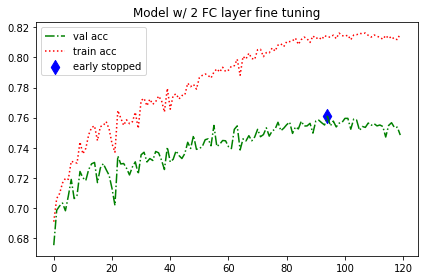

In [ ]:
plt.plot(epochs, val_acc, label="val acc", color="green", linestyle='-.')
plt.plot(epochs, train_acc, label="train acc", color="red",linestyle=':')
plt.scatter([max_epoch], [max_validation],color="blue", marker="d", label="early stopped", s=100 )
plt.title("Model w/ 2 FC layer fine tuning")
plt.legend()
plt.tight_layout()
plt.savefig('fctuning2[224].png',dpi=600)
plt.show()
torch.save(val_acc, 'val_acc2b[224].pt')
torch.save(train_acc, 'train_acc2b[224].pt')

In [ ]:
from google.colab import files
files.download('fctuning2[224].png') 
files.download('val_acc2b[224].pt') 
files.download('train_acc2b[224].pt') 
files.download('./only2FC.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>